In [1]:
# Uncomment and run this cell if you're on Colab or Kaggle:
!git clone https://github.com/nlp-with-transformers/notebooks.git
%cd notebooks
from install import *
install_requirements()

fatal: destination path 'notebooks' already exists and is not an empty directory.
/content/notebooks
⏳ Installing base requirements ...
✅ Base requirements installed!
⏳ Installing Git LFS ...
✅ Git LFS installed!


In [2]:
from utils import *
setup_chapter()

No GPU was detected! This notebook can be *very* slow without a GPU 🐢
Go to Runtime > Change runtime type and select a GPU hardware accelerator.
Using transformers v4.16.2
Using datasets v1.16.1


# Text Generation

<img alt="LM Meta Learning" width="800" caption="During pretraining, language models are exposed to sequences of tasks that can be adapted during inference (courtesy of Tom B. Brown)" src="https://github.com/nlp-with-transformers/notebooks/blob/main/images/chapter05_lm-meta-learning.png?raw=1" id="lm-meta-learning"/>

<img alt="Meena" width="300" caption="Meena on the left telling a corny joke to a human on the right (courtesy of Daniel Adiwardana and Thang Luong)" src="https://github.com/nlp-with-transformers/notebooks/blob/main/images/chapter05_meena.png?raw=1" id="meena"/>

## The Challenge with Generating Coherent Text

<img alt="Text generation" width="700" caption="Generating text from an input sequence by adding a new word to the input at each step" src="https://github.com/nlp-with-transformers/notebooks/blob/main/images/chapter05_text-generation.png?raw=1" id="text-generation"/>

## Greedy Search Decoding

In [3]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:1435: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(resolved_archive_file, map

In [4]:
tokenizer

PreTrainedTokenizerFast(name_or_path='gpt2', vocab_size=50257, model_max_len=1024, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>'})

In [5]:
tokenizer.all_special_tokens

['<|endoftext|>']

In [6]:
# Exploratory:
x = torch.tensor([0.35, 0.5, 0.15])
torch.argsort(x, dim=-1, descending=True)

tensor([1, 0, 2])

In [7]:
input_txt = "Transformers are the"
tokenizer(input_txt, return_tensors="pt")

{'input_ids': tensor([[41762,   364,   389,   262]]), 'attention_mask': tensor([[1, 1, 1, 1]])}

In [8]:
tokenizer.tokenize(input_txt)

['Transform', 'ers', 'Ġare', 'Ġthe']

In [9]:
input_ids = tokenizer(input_txt, return_tensors="pt")['input_ids'].to(device)
iterations = []
n_steps = 8
choices_per_step = 5

In [10]:
tokenizer.convert_ids_to_tokens(input_ids[0])

['Transform', 'ers', 'Ġare', 'Ġthe']

In [11]:
tokenizer.decode(input_ids[0])

'Transformers are the'

In [12]:
with torch.no_grad():
    for _ in range(n_steps):
        iteration = dict()
        iteration['Input'] = tokenizer.decode(input_ids[0])
        print(iteration)
        break

{'Input': 'Transformers are the'}


In [13]:
with torch.no_grad():
    for _ in range(n_steps):
        iteration = dict()
        iteration['Input'] = tokenizer.decode(input_ids[0])
        output = model(input_ids=input_ids)
        print(type(output.logits))
        print(output.logits.shape)
        break

<class 'torch.Tensor'>
torch.Size([1, 4, 50257])


The shape is (batch size, sequence length, vocab size).

In [14]:
with torch.no_grad():
    for _ in range(n_steps):
        iteration = dict()
        iteration['Input'] = tokenizer.decode(input_ids[0])
        output = model(input_ids=input_ids)
        # Select logits of the first (only) example in the batch and the last token, and apply softmax:
        next_token_logits = output.logits[0, -1, :]
        print(next_token_logits.shape)
        next_token_probs = torch.softmax(next_token_logits, dim=-1)
        print(next_token_probs.shape)
        break

torch.Size([50257])
torch.Size([50257])


In [15]:
with torch.no_grad():
    for _ in range(n_steps):
        iteration = dict()
        iteration['Input'] = tokenizer.decode(input_ids[0])
        output = model(input_ids=input_ids)
        # Select logits of the first (only) example in the batch and the last token, and apply softmax:
        next_token_logits = output.logits[0, -1, :]
        next_token_probs = torch.softmax(next_token_logits, dim=-1)
        sorted_ids = torch.argsort(next_token_probs, dim=-1, descending=True)
        print(sorted_ids)
        break

tensor([  749,   976,   691,  ...,   208,   179, 37574])


In [16]:
with torch.no_grad():
    for _ in range(n_steps):
        iteration = dict()
        iteration['Input'] = tokenizer.decode(input_ids[0])
        output = model(input_ids=input_ids)
        # Select logits of the first (only) example in the batch and the last token, and apply softmax:
        next_token_logits = output.logits[0, -1, :]
        next_token_probs = torch.softmax(next_token_logits, dim=-1)
        sorted_ids = torch.argsort(next_token_probs, dim=-1, descending=True)
        # Store tokens with highest probabilities:
        for choice_idx in range(choices_per_step):
            token_id = sorted_ids[choice_idx]
            token_prob = next_token_probs[token_id].cpu().numpy()
            token_choice = f"{tokenizer.decode(token_id)} ({100 * token_prob:.2f}%)"
            iteration[f'Choice {choice_idx + 1}'] = token_choice
        print(iteration)
        break

{'Input': 'Transformers are the', 'Choice 1': ' most (9.76%)', 'Choice 2': '
same (2.94%)', 'Choice 3': ' only (2.87%)', 'Choice 4': ' best (2.38%)', 'Choice
5': ' first (1.77%)'}


In [17]:
sorted_ids

tensor([  749,   976,   691,  ...,   208,   179, 37574])

In [18]:
sorted_ids[0]

tensor(749)

**Note:** `sorted_ids[0]` is the most likely token at the current time step.

In [19]:
sorted_ids[0, None]

tensor([749])

In [20]:
sorted_ids[None, 0, None]

tensor([[749]])

In [21]:
with torch.no_grad():
    for _ in range(n_steps):
        iteration = dict()
        iteration['Input'] = tokenizer.decode(input_ids[0])
        output = model(input_ids=input_ids)
        # Select logits of the first (only) example in the batch and the last token, and apply softmax:
        next_token_logits = output.logits[0, -1, :]
        next_token_probs = torch.softmax(next_token_logits, dim=-1)
        sorted_ids = torch.argsort(next_token_probs, dim=-1, descending=True)
        # Store tokens with highest probabilities:
        for choice_idx in range(choices_per_step):
            token_id = sorted_ids[choice_idx]
            token_prob = next_token_probs[token_id].cpu().numpy()
            token_choice = f"{tokenizer.decode(token_id)} ({100 * token_prob:.2f}%)"
            iteration[f'Choice {choice_idx + 1}'] = token_choice
        # Append predicted next token to input:
        input_ids = torch.cat([input_ids, sorted_ids[None, 0, None]], dim=-1)
        iterations.append(iteration)
iterations

[{'Input': 'Transformers are the',
  'Choice 1': ' most (9.76%)',
  'Choice 2': ' same (2.94%)',
  'Choice 3': ' only (2.87%)',
  'Choice 4': ' best (2.38%)',
  'Choice 5': ' first (1.77%)'},
 {'Input': 'Transformers are the most',
  'Choice 1': ' common (22.90%)',
  'Choice 2': ' powerful (6.88%)',
  'Choice 3': ' important (6.32%)',
  'Choice 4': ' popular (3.95%)',
  'Choice 5': ' commonly (2.14%)'},
 {'Input': 'Transformers are the most common',
  'Choice 1': ' type (15.06%)',
  'Choice 2': ' types (3.31%)',
  'Choice 3': ' form (1.91%)',
  'Choice 4': ' way (1.89%)',
  'Choice 5': ' and (1.49%)'},
 {'Input': 'Transformers are the most common type',
  'Choice 1': ' of (83.13%)',
  'Choice 2': ' in (3.16%)',
  'Choice 3': '. (1.92%)',
  'Choice 4': ', (1.63%)',
  'Choice 5': ' for (0.88%)'},
 {'Input': 'Transformers are the most common type of',
  'Choice 1': ' particle (1.55%)',
  'Choice 2': ' object (1.02%)',
  'Choice 3': ' light (0.71%)',
  'Choice 4': ' energy (0.67%)',
  'Cho

In [22]:
import pandas as pd

pd.set_option('display.max_colwidth', 0)
pd.DataFrame(iterations)

,Input,Choice 1,Choice 2,Choice 3,Choice 4,Choice 5
0,Transformers are the,most (9.76%),same (2.94%),only (2.87%),best (2.38%),first (1.77%)
1,Transformers are the most,common (22.90%),powerful (6.88%),important (6.32%),popular (3.95%),commonly (2.14%)
2,Transformers are the most common,type (15.06%),types (3.31%),form (1.91%),way (1.89%),and (1.49%)
3,Transformers are the most common type,of (83.13%),in (3.16%),. (1.92%),", (1.63%)",for (0.88%)
4,Transformers are the most common type of,particle (1.55%),object (1.02%),light (0.71%),energy (0.67%),objects (0.66%)
5,Transformers are the most common type of particle,. (14.26%),in (11.57%),that (10.19%),", (9.57%)",accelerator (5.81%)
6,Transformers are the most common type of particle.,They (17.48%),\n (15.19%),The (7.06%),These (3.09%),In (3.07%)
7,Transformers are the most common type of particle. They,are (38.78%),have (8.14%),can (7.98%),'re (5.04%),consist (1.57%)


In [23]:
input_ids = tokenizer(input_txt, return_tensors="pt")['input_ids'].to(device)
output = model.generate(input_ids, max_new_tokens=n_steps, do_sample=False)
output

tensor([[41762,   364,   389,   262,   749,  2219,  2099,   286, 18758,    13,
          1119,   389]])

In [24]:
tokenizer.decode(output[0])

'Transformers are the most common type of particle. They are'

In [25]:
help(model.generate)

Help on method generate in module transformers.generation_utils:

generate(inputs: Optional[torch.Tensor] = None, max_length: Optional[int] = None, min_length: Optional[int] = None, do_sample: Optional[bool] = None, early_stopping: Optional[bool] = None, num_beams: Optional[int] = None, temperature: Optional[float] = None, top_k: Optional[int] = None, top_p: Optional[float] = None, repetition_penalty: Optional[float] = None, bad_words_ids: Optional[Iterable[int]] = None, bos_token_id: Optional[int] = None, pad_token_id: Optional[int] = None, eos_token_id: Optional[int] = None, length_penalty: Optional[float] = None, no_repeat_ngram_size: Optional[int] = None, encoder_no_repeat_ngram_size: Optional[int] = None, num_return_sequences: Optional[int] = None, max_time: Optional[float] = None, max_new_tokens: Optional[int] = None, decoder_start_token_id: Optional[int] = None, use_cache: Optional[bool] = None, num_beam_groups: Optional[int] = None, diversity_penalty: Optional[float] = None, pr

In [26]:
max_length = 128
input_txt = """In a shocking finding, scientist discovered \
a herd of unicorns living in a remote, previously unexplored \
valley, in the Andes Mountains. Even more surprising to the \
researchers was the fact that the unicorns spoke perfect English.\n\n
"""
input_ids = tokenizer(input_txt, return_tensors="pt")['input_ids'].to(device)
output_greedy = model.generate(input_ids, max_length=max_length, do_sample=False)
output_greedy

tensor([[  818,   257, 14702,  4917,    11, 11444,  5071,   257, 27638,   286,
         28000, 19942,  2877,   287,   257,  6569,    11,  4271, 31286,  1850,
         19272,    11,   287,   262,   843,   274, 21124,    13,  3412,   517,
          6452,   284,   262,  4837,   373,   262,  1109,   326,   262, 28000,
         19942,  5158,  2818,  3594,    13,   628,   198,     1,   464, 28000,
         19942,   547,   845, 12661,    11,   290,   484,   547,   845, 12661,
           553,   531,  1583,    13,  3271,   311,    13,   311, 28210,    11,
           257,  6240,   286, 45424,   379,   262,  2059,   286,  3442,    11,
         14727,    13,   366,  2990,   547,   845, 12661,    11,   290,   484,
           547,   845, 12661,    11,   290,   484,   547,   845, 12661,    11,
           290,   484,   547,   845, 12661,    11,   290,   484,   547,   845,
         12661,    11,   290,   484,   547,   845, 12661,    11,   290,   484,
           547,   845, 12661,    11,   290,   484,  

In [27]:
output_greedy.shape

torch.Size([1, 128])

In [28]:
tokenizer.decode(output_greedy[0])

'In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.\n\n\n"The unicorns were very intelligent, and they were very intelligent," said Dr. David S. Siegel, a professor of anthropology at the University of California, Berkeley. "They were very intelligent, and they were very intelligent, and they were very intelligent, and they were very intelligent, and they were very intelligent, and they were very intelligent, and they were very intelligent, and they were very'

## Beam Search Decoding

<img alt="Beam search" width="700" caption="Beam search with two beams—the most probable sequences at each timestep are highlighted in blue" src="https://github.com/nlp-with-transformers/notebooks/blob/main/images/chapter05_beam-search.png?raw=1" id="beam-search"/>

In [29]:
0.5**1024

5.562684646268003e-309

In [30]:
import numpy as np

np.log(5.562684646268003e-309)

-709.782712893384

Equivalent to:

In [31]:
1024 * np.log(0.5)

-709.782712893384

And to:

In [32]:
sum([np.log(0.5)] * 1024)

-709.7827128933695

This is because log(0.5**1024) = log(0.5 * 0.5 * ... * 0.5) = log(0.5) + log(0.5) + ... + log(0.5), which is the above expression. If 1024 were 2, we would be summing the elements of the following list:

In [33]:
[np.log(0.5)] * 2

[-0.6931471805599453, -0.6931471805599453]

Now, let's build up a couple of functions:

In [34]:
# No attempt made at understanding this cell (so far).
import torch.nn.functional as F

def log_probs_from_logits(logits, labels):
    logp = F.log_softmax(logits, dim=-1)
    logp_label = torch.gather(logp, 2, labels.unsqueeze(2)).squeeze(-1)
    return logp_label

In [35]:
# No attempt made at understanding this cell (so far).
def sequence_logprob(model, labels, input_len=0):
    with torch.no_grad():
        output = model(labels)
        log_probs = log_probs_from_logits(output.logits[:, :-1, :], labels[:, 1:])
        seq_log_prob = torch.sum(log_probs[:, input_len:])
    return seq_log_prob.cpu().numpy()

In [36]:
logp = sequence_logprob(model, output_greedy, input_len=len(input_ids[0]))
print(tokenizer.decode(output_greedy[0]))
print(f"\nlog-prob: {logp:.2f}")

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


"The unicorns were very intelligent, and they were very intelligent," said Dr.
David S. Siegel, a professor of anthropology at the University of California,
Berkeley. "They were very intelligent, and they were very intelligent, and they
were very intelligent, and they were very intelligent, and they were very
intelligent, and they were very intelligent, and they were very intelligent, and
they were very

log-prob: -83.32


In [37]:
output_beam = model.generate(input_ids, max_length=max_length, num_beams=5, do_sample=False)
logp = sequence_logprob(model, output_beam, input_len=len(input_ids[0]))
print(tokenizer.decode(output_beam[0]))
print(f"\nlog-prob: {logp:.2f}")

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


The researchers, from the University of California, San Diego, and the
University of California, Santa Cruz, found that the unicorns were able to
communicate with each other in a way that was similar to that of human speech.


"The unicorns were able to communicate with each other in a way that was similar
to that of human speech," said study co-lead author Dr. David J.

log-prob: -78.34


In [38]:
output_beam = model.generate(input_ids, max_length=max_length, num_beams=5, do_sample=False, no_repeat_ngram_size=2)
logp = sequence_logprob(model, output_beam, input_len=len(input_ids[0]))
print(tokenizer.decode(output_beam[0]))
print(f"\nlog-prob: {logp:.2f}")

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


The researchers, from the University of California, San Diego, and the National
Science Foundation (NSF) in Boulder, Colorado, were able to translate the words
of the unicorn into English, which they then translated into Spanish.

"This is the first time that we have translated a language into an English
language," said study co-author and NSF professor of linguistics and
evolutionary biology Dr.

log-prob: -101.87


## Sampling Methods

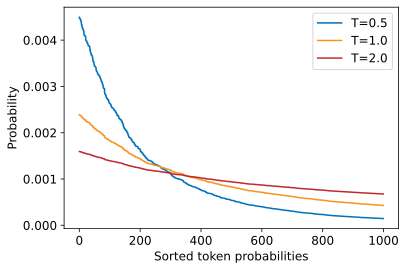

In [39]:
# For generating plot; just run:
import matplotlib.pyplot as plt
import numpy as np

def softmax(logits, T=1):
    e_x = np.exp(logits / T)
    return e_x / e_x.sum()

logits = np.exp(np.random.random(1000))
sorted_logits = np.sort(logits)[::-1]
x = np.arange(1000)

for T in [0.5, 1.0, 2.0]:
    plt.step(x, softmax(sorted_logits, T), label=f"T={T}")
plt.legend(loc="best")
plt.xlabel("Sorted token probabilities")
plt.ylabel("Probability")
plt.show()

In [40]:
torch.manual_seed(42);

**Note:** In the "*How to generate text*" blog post, we used `transformers.set_seed`.

In [41]:
output_temp = model.generate(input_ids, max_length=max_length, do_sample=True, temperature=2.0, top_k=0)
print(tokenizer.decode(output_temp[0]))

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


Feed Boost Year Hampe Eagle Rouse Symbol Steal Therefore inappropriate Sprite 69
151 NO-James Ridene Castle joviespantry Spy legislative Truever Beast Pascal
Hermes Musk Central Bombsaver democracy Civil codesRosSkill lives your
choicesFight scan buggy huntDun 550 micro brightly Byrne Join Bittees Radiustool
toddlersAustin Ahmad Alexandophyete four 32 Democratic Pledgeson idea
Masterserrors order againtonache013 robot Palest VP carrotsinvest


In [42]:
torch.manual_seed(42);

In [43]:
output_temp = model.generate(input_ids, max_length=max_length, do_sample=True, temperature=0.5, top_k=0)
print(tokenizer.decode(output_temp[0]))

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


"They didn't speak any different languages than normal humans, and they were
able to communicate with us in the same way that we communicate with our cousins
in other parts of the world," says Dr. David W. Waddell, a professor of animal
behavior and ecology at the University of California, San Francisco.


The unicorns were found in a valley in the Andes Mountains, about 50


## Top-k and Nucleus Sampling

In [44]:
# For generating plot; just run:
torch.manual_seed(42);

In [45]:
# For generating plot; just run:
input_txt = """In a shocking finding, scientist discovered \
a herd of unicorns living in a remote, previously unexplored \
valley, in the Andes Mountains. Even more surprising to the \
researchers was the fact that the unicorns spoke perfect English.\n\n
"""
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)

In [46]:
# For generating plot; just run:
import torch.nn.functional as F

with torch.no_grad():
    output = model(input_ids=input_ids)
    next_token_logits = output.logits[:, -1, :]
    probs = F.softmax(next_token_logits, dim=-1).detach().cpu().numpy()

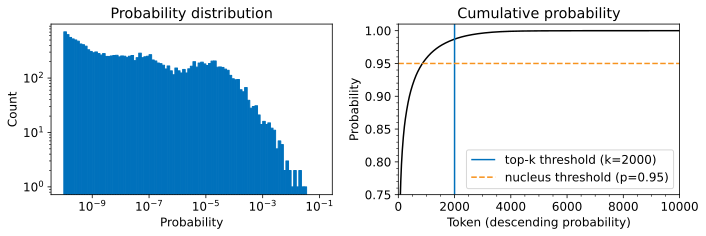

In [47]:
# For generating plot; just run:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 2, figsize=(10, 3.5))

axes[0].hist(probs[0], bins=np.logspace(-10, -1, 100), color="C0", edgecolor="C0")
axes[0].set_xscale("log")
axes[0].set_yscale("log")
axes[0].set_title("Probability distribution")
axes[0].set_xlabel("Probability")
axes[0].set_ylabel("Count")
# axes[0].grid(which="major")

axes[1].plot(np.cumsum(np.sort(probs[0])[::-1]), color="black")
axes[1].set_xlim([0, 10000])
axes[1].set_ylim([0.75, 1.01])
axes[1].set_title("Cumulative probability")
axes[1].set_ylabel("Probability")
axes[1].set_xlabel("Token (descending probability)")
# axes[1].grid(which="major")
axes[1].minorticks_on()
# axes[1].grid(which='minor', linewidth='0.5')
top_k_label = 'top-k threshold (k=2000)'
top_p_label = 'nucleus threshold (p=0.95)'
axes[1].vlines(x=2000, ymin=0, ymax=2, color='C0', label=top_k_label)
axes[1].hlines(y=0.95, xmin=0, xmax=10000, color='C1', label=top_p_label, linestyle='--')
axes[1].legend(loc='lower right')
plt.tight_layout()

In [48]:
torch.manual_seed(42);

In [49]:
output_topk = model.generate(input_ids, max_length=max_length, do_sample=True, top_k=50)
print(tokenizer.decode(output_topk[0]))

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


To get to the mountains, the researchers first needed to make sure that each of
the animals, except those the researchers said were native to northern
countries, didn't get injured.


The researchers also found only one unicorn, also believed to be the same
species as the original unicorn, who, according to the Spanish government, is
described only in the journal Dinos Métropolitana.





In [50]:
torch.manual_seed(42);

In [51]:
output_topp = model.generate(input_ids, max_length=max_length, do_sample=True, top_p=0.9)
print(tokenizer.decode(output_topp[0]))

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


To get to the mountains, the researchers first needed to make sure that each of
the animals, except for the unicorns, were properly social. To do this, they had
to use technology to help the group to understand each other and to help the
animal communicate with one another.


It took only 15 minutes, but the animals began to talk to each other in a way
that they thought was human


## Which Decoding Method Is Best?

## Conclusion